In [ ]:
# Run this cell only the very first time to execute this notebook

%cd /content/drive/MyDrive
%mkdir ECE-4803-Assignment-5-files
%cd ECE-4803-Assignment-5-files
%mkdir data

%mkdir {data/train,data/test,pretrained_models,finetuned_models,results}

%cd data/train
!wget "https://zenodo.org/record/4299330/files/train.csv"
!wget "https://zenodo.org/record/4299330/files/train.zip"

%cd ../test
!wget "https://zenodo.org/record/4299330/files/test.csv"
!wget "https://zenodo.org/record/4299330/files/test.zip"


In [1]:
# run this cell every time you execute the notebook afresh after the first time

import os

root = '/content/drive/MyDrive/ECE-4803-Assignment-5-files'
train_directory = '/content/drive/My Drive/ECE-4803-Assignment-5-files/data/train'
test_directory = '/content/drive/My Drive/ECE-4803-Assignment-5-files/data/test'
os.chdir(root)



In [2]:
# inspect data 

os.chdir(root+'/data/train')

import pandas as pd

df = pd.read_csv('train.csv')
df.head()

,imageID,class,background,perspective,challengeType,challengeLevel
0,0,1,1,1,1,0
1,1,2,1,1,1,0
2,2,3,1,1,1,0
3,3,4,1,1,1,0
4,4,5,1,1,1,0


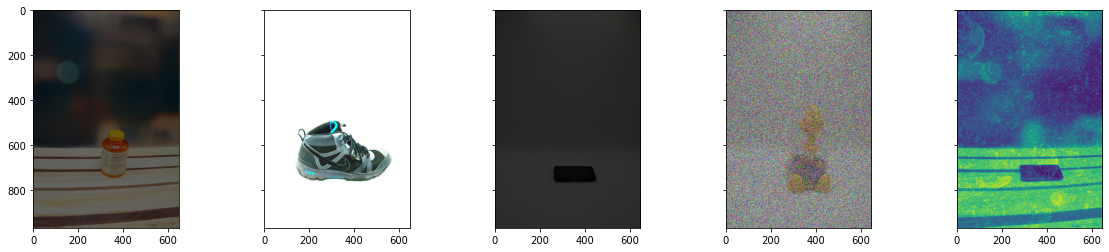

In [3]:
import random
from zipfile import ZipFile
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class_num = 5  # has to be a number between 1 and 10

zipobj = ZipFile('train.zip')
file_IDs = zipobj.namelist()[1:]  # all fileIds in the folder

random.shuffle(file_IDs)
filenames = file_IDs[:5]

with ZipFile('train.zip','r') as zipObject:
  for filename in filenames:
     zipObject.extract(filename)


fig, ax = plt.subplots(1,5, sharey=True, figsize=(20,4))

for filename,axis in zip(filenames, ax.flatten()):
  img=mpimg.imread(filename)
  axis.imshow(img)

plt.show()

shutil.rmtree('train')

In [ ]:
#download pytorch model only once!!!

%cd /content/drive/MyDrive/ECE-4803-Assignment-5-files/pretrained_models/
!wget "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"

In [6]:
# load models and label dictionary

import torch
from torchvision.models import alexnet

# load dictionary for alexnet labels
label_map = torch.load("/content/drive/MyDrive/ECE-4803-Assignment-5-files/label_dict.pth")

# load model 
model = alexnet()
model.load_state_dict(torch.load('/content/drive/MyDrive/ECE-4803-Assignment-5-files/pretrained_models/alexnet-owt-4df8aa71.pth'))


<All keys matched successfully>

In [ ]:
# create a training dataset (only run once!!!)

import os
import numpy as np
import random
from zipfile import ZipFile
import shutil

train_directory = '/content/drive/My Drive/ECE-4803-Assignment-5-files/data/train'
os.chdir(train_directory)

training_points_per_class = 15  # num of images per class

# create directory to store extracted training images
if not os.path.isdir('train_imgs'):
  os.mkdir('train_imgs')
else:
  pass

# dataframe of class labels and IDs
df = pd.read_csv('train.csv')

for i, class_num in enumerate(range(1, 11)):

  train_file_IDs = list(df.loc[df['class']==class_num]['imageID'].to_numpy()) # get all the image IDs for that class
  train_file_IDs = ['train/'+str(ID).zfill(5)+'.jpg' for ID in train_file_IDs] # convert IDs to string paths
  
  # make directory for class
  if not os.path.isdir('train_imgs/'+str(i)):
    os.mkdir('train_imgs/'+str(i))
  else:
    pass

  random.shuffle(train_file_IDs)
  filenames = train_file_IDs[:training_points_per_class]

  with ZipFile('train.zip','r') as zipObject:
    for filename in filenames:
      zipObject.extract(filename)
      shutil.move(filename,'train_imgs/'+str(i))
  
os.rmdir('train')


In [ ]:
# create a directory of test images

import os
import numpy as np
import random
from zipfile import ZipFile
import shutil

test_directory = '/content/drive/My Drive/ECE-4803-Assignment-5-files/data/test'
os.chdir(test_directory)

test_points_per_class = 5  # num of test images per class

# create directory to store extracted test images
if not os.path.isdir('test_imgs'):
  os.mkdir('test_imgs')
else:
  pass

# dataframe of class labels and IDs
df = pd.read_csv('test.csv')

for i, class_num in enumerate(range(1, 11)):
  
  # make directory for class
  if not os.path.isdir('test_imgs/'+str(i)):
    os.mkdir('test_imgs/'+str(i))
  else:
    pass

  test_file_IDs = list(df.loc[df['class']==class_num]['imageID'].to_numpy()) # get all the image IDs for that class
  test_file_IDs = ['test/'+str(ID).zfill(5)+'.jpg' for ID in test_file_IDs] # convert IDs to string paths

  random.shuffle(test_file_IDs)
  filenames = test_file_IDs[:test_points_per_class]

  with ZipFile('test.zip','r') as zipObject:
    for filename in filenames:
      zipObject.extract(filename)
      shutil.move(filename,'test_imgs/'+str(i))
  
os.rmdir('test')


In [7]:
# create a dataloader

import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms

preprocess = transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
       ])

# set up train loader
train_dataset = ImageFolder(root=train_directory+'/train_imgs', transform=preprocess)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

# set up test loader
test_dataset = ImageFolder(root=test_directory+'/test_imgs', transform=preprocess)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)


In [8]:
# Finetune model
import torch.nn as nn

# change last layer of model
model.classifier[6] = nn.Linear(4096, 10)
model.to('cuda')

# define loss
loss = nn.CrossEntropyLoss()

# set up optimizer
optimizer = torch.optim.Adagrad(model.classifier[6].parameters(), lr=1e-3)

for epoch in range(20):
  model.train()
  optimizer.zero_grad()

  loss_val = 0
  for i, (x, y) in enumerate(trainloader):
    input = x.to('cuda')
    target = y.to('cuda')
    out = model(input)
    loss_val += loss(out, target)
  
  loss_val = loss_val / i
  loss_val.backward() 
  optimizer.step()

  print('Epoch: {} | Loss:{:0.4f}'.format(epoch, loss_val.item()))



Epoch: 0 | Loss:2.4817
Epoch: 1 | Loss:1.9408
Epoch: 2 | Loss:1.6838
Epoch: 3 | Loss:1.4631
Epoch: 4 | Loss:1.3228
Epoch: 5 | Loss:1.2318
Epoch: 6 | Loss:1.1419
Epoch: 7 | Loss:1.0611
Epoch: 8 | Loss:1.0295
Epoch: 9 | Loss:0.9799
Epoch: 10 | Loss:0.9326
Epoch: 11 | Loss:0.9145
Epoch: 12 | Loss:0.8565
Epoch: 13 | Loss:0.8280
Epoch: 14 | Loss:0.8329
Epoch: 15 | Loss:0.7978
Epoch: 16 | Loss:0.7710
Epoch: 17 | Loss:0.7638
Epoch: 18 | Loss:0.7309
Epoch: 19 | Loss:0.7325


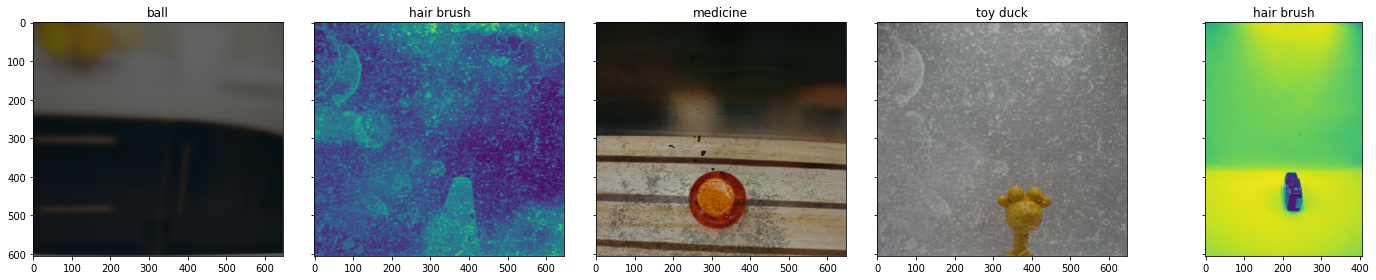

In [9]:
# visualize predictions on train data

os.chdir(train_directory)

class_num = 4  # has to be a number between 1 and 10

zipobj = ZipFile('train.zip')
file_IDs = zipobj.namelist()[1:]

random.shuffle(file_IDs)
filenames = file_IDs[:5]

with ZipFile('train.zip','r') as zipObject:
  for filename in filenames:
     zipObject.extract(filename)

from PIL import Image
from torchvision import transforms
import numpy as np
import torch
import torch.nn.functional as F

label_map = {0:'camera',
             1:'cone',
             2:'ball',
             3:'pan',
             4:'toy duck',
             5:'smartphone',
             6:'hair brush',
             7:'calculator',
             8:'medicine',
             9:'shoe'}


def pred_img_label(img):
    '''Function performs inference of label on given image.'''
    
    input_image = Image.fromarray(np.uint8(img)).convert('RGB')
    preprocess = transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
       ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
       input_batch = input_batch.to('cuda')
       model.to('cuda')

    with torch.no_grad():
       output = model(input_batch)
       output = F.softmax(output, dim=1)
        
    top_class_idx = output.argmax()
    pred_class = label_map[top_class_idx.item()]
    
    return pred_class


fig, ax = plt.subplots(1,5, sharey=True, figsize=(20,4))

for filename,axis in zip(filenames, ax.flatten()):
  img=mpimg.imread(filename)
  pred_class = pred_img_label(img)
  pred_class = pred_class.split(',')[0]  # get only the first class name for each category
  axis.imshow(img)
  axis.set_title(pred_class)

plt.tight_layout()    
plt.show()

shutil.rmtree('train')

IOUs:  [0.14285714 0.28571429 0.         0.2        0.09090909 0.15
 0.         0.22222222 0.16666667 0.11111111]

mean IOU:  0.13694805194805196

Accuracy:  0.24


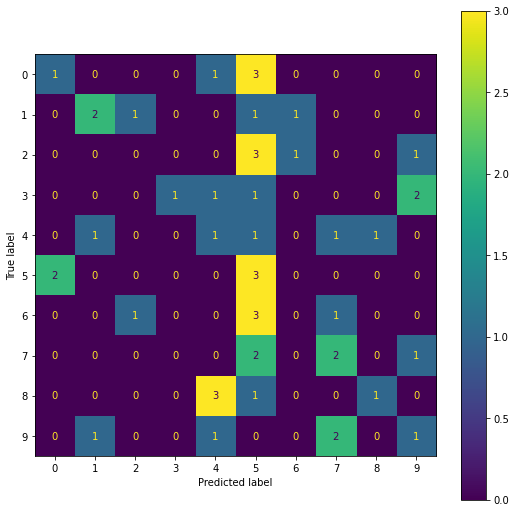

In [14]:
# quantitive evaluation metrics on test

y_true = []
y_pred = []

with torch.no_grad():
    for i, (x, y) in enumerate(testloader):
      x = x.to('cuda')
      out = model(x)
      y_pred.append(out.argmax().item())
      y_true.append(y.item())

from sklearn.metrics import jaccard_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

IOUs = jaccard_score(y_pred, y_true, labels=np.arange(10), average=None)
accuracy = accuracy_score(y_pred, y_true)

print('IOUs: ', IOUs)
print('\nmean IOU: ', IOUs.mean())
print('\nAccuracy: ',accuracy)

cf = confusion_matrix(y_true, y_pred, labels=np.arange(10))

fig, ax = plt.subplots(figsize=(9,9))
disp = ConfusionMatrixDisplay(cf, np.arange(10))
disp.plot(ax=ax)
plt.show()


## Anomaly Detection with Autoencoders

In [76]:
# define training loader for given class

from torch.utils.data import Dataset, DataLoader
import zipfile as ZipFile

class_num = 3  # number from 1 to 10

class AnomalyDataset(Dataset):
  def __init__(self, data_class_root):
    self.root = data_class_root
    self.filenames = os.listdir(data_class_root)  # extract all filenames
    self.preprocess = transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                               std=[0.229, 0.224, 0.225]),
                                          ])

  
  def __getitem__(self, index):
    img=mpimg.imread(self.root+'/'+self.filenames[index])
    input_image = Image.fromarray(np.uint8(img)).convert('RGB')
    input_tensor = preprocess(input_image)

    # move the input to GPU for speed if available
    if torch.cuda.is_available():
       input_tensor = input_tensor.to('cuda')

    return input_tensor
  
  def __len__(self):
    return len(self.filenames)


# set up loader
anomaly_dataset = AnomalyDataset(train_directory+'/train_imgs/'+str(class_num-1))
anomaly_loader = DataLoader(anomaly_dataset, batch_size=1)

# set up test loader (as before)
test_dataset = ImageFolder(root=test_directory+'/test_imgs', transform=preprocess)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# set up evaluation loader
eval_dataset = ImageFolder(root=train_directory+'/train_imgs', transform=preprocess)
evalloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)



In [77]:
# set up the convolutional autoencoder model

import torch
import torch.nn as nn

class GradConCAE(nn.Module):
    def __init__(self, in_channel=3):
        super(GradConCAE, self).__init__()

        self.down = nn.Sequential(
            nn.Conv2d(in_channel, 32, 4, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 4, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, stride=2, padding=2),
            nn.ReLU()
        )

        self.up = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=2),  # output 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # output 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 4, stride=2, padding=1),  # output 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channel, 4, stride=2, padding=1),  # output 28x28
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        z = self.down(x)
        return self.up(z)



In [78]:
# training loop 

num_epochs = 100  # num of epochs for training 

model = GradConCAE().to('cuda')  # defines model
loss_func = torch.nn.MSELoss()  # MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # adam optimizer

model.train()
for epoch in range(num_epochs):
    for batch_idx, img in enumerate(anomaly_loader):
        optimizer.zero_grad()
        recon_img = model(img)
        loss = loss_func(img, recon_img)
        loss.backward()
        optimizer.step()
        
                   
    print("Epoch: {} | Loss: {}".format(epoch, loss.item()))


Epoch: 0 | Loss: 2.0571212768554688
Epoch: 1 | Loss: 1.3999757766723633
Epoch: 2 | Loss: 0.8391282558441162
Epoch: 3 | Loss: 0.25361448526382446
Epoch: 4 | Loss: 0.17385829985141754
Epoch: 5 | Loss: 0.17096658051013947
Epoch: 6 | Loss: 0.17379499971866608
Epoch: 7 | Loss: 0.1518978625535965
Epoch: 8 | Loss: 0.12427996844053268
Epoch: 9 | Loss: 0.1045762374997139
Epoch: 10 | Loss: 0.10886243730783463
Epoch: 11 | Loss: 0.10089468955993652
Epoch: 12 | Loss: 0.09421615302562714
Epoch: 13 | Loss: 0.07869267463684082
Epoch: 14 | Loss: 0.07689899206161499
Epoch: 15 | Loss: 0.06687673926353455
Epoch: 16 | Loss: 0.06183009222149849
Epoch: 17 | Loss: 0.05878663808107376
Epoch: 18 | Loss: 0.05661855265498161
Epoch: 19 | Loss: 0.05342644825577736
Epoch: 20 | Loss: 0.04986747354269028
Epoch: 21 | Loss: 0.046467941254377365
Epoch: 22 | Loss: 0.04499911516904831
Epoch: 23 | Loss: 0.1060372143983841
Epoch: 24 | Loss: 0.05752233788371086
Epoch: 25 | Loss: 0.06007761508226395
Epoch: 26 | Loss: 0.2350901

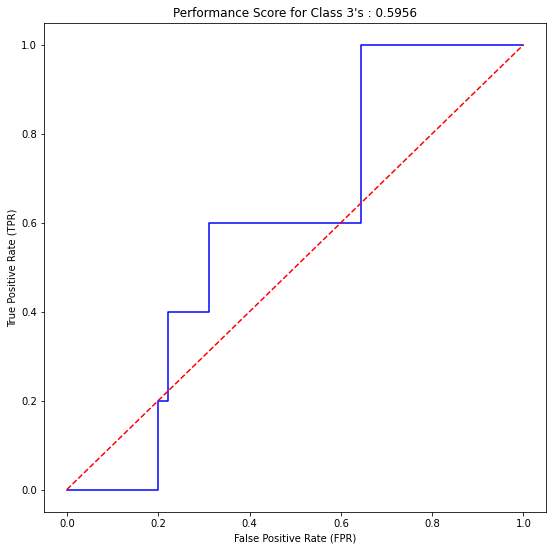

In [80]:
# test for inference using evaluation metrics

y_true = []  # set up an array to store true positive labels
scores = []  # array to store confidence scores for predicting positive class.

with torch.no_grad():
  model.eval()  # set model to evaluate mode 
  for i, (img, label) in enumerate(testloader):
      img = img.to('cuda')
      img_recon = model(img)
      loss = loss_func(img, recon_img)
      
      y_true.append(label)
      scores.append(-loss.item())

from sklearn.metrics import roc_curve, roc_auc_score

y_true = np.array(y_true)
scores = np.array(scores)

# fpr and tpr
fpr, tpr, _ = roc_curve(y_true, scores, pos_label=class_num-1) # obtain true and false positive rates

pos_class_mask = y_true == class_num-1
y_true[pos_class_mask] = 1
y_true[~pos_class_mask] = 0

auroc = roc_auc_score(y_true, scores) # obtain auroc

# plot ROC
fig, ax = plt.subplots(figsize=(9,9))
ax.plot(fpr, tpr, 'b-', label='ROC Curve')
ax.plot([0,1],[0,1],'r--')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title("Performance Score for Class {}'s : {:0.4f}".format(class_num, auroc), fontsize=12)
plt.show()             


